### In this notebook we read in data needed for MARBL and generate 1D input files. 
In MOM_input we need to specify the following initial condition files:

These files are currently read in from the direcotry "CESM_INPUTDIR", which defaults to "/glade/work/mlevy/cesm_inputdata". This is hardcoded in MOM6-examples/src/MOM6/src/tracer/MARBL_tracers.F90.


In [2]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [13]:
%cd /glade/work/mlevy/cesm_inputdata/
IC_FILE               =  xr.open_dataset('ecosys_jan_IC_omip_MOM_tx0.66v1_c221027.nc') #Combination of WOA and other fields from POP
MARBL_FESEDFLUX_FILE  =  xr.open_dataset('fesedflux_total_reduce_oxic_tx0.66v1.c211109.nc') #From Matt's notebook based on POP output
MARBL_FEVENTFLUX_FILE =  xr.open_dataset('feventflux_5gmol_tx0.66v1.c211109.nc') 
#https://github.com/marbl-ecosys/marbl-forcing/tree/master/Fe_sediment_flux
#https://github.com/marbl-ecosys/marbl-forcing/tree/master/initial_conditions
#https://github.com/mnlevy1981/marbl-forcing/blob/MOM_ic/initial_conditions/gen_mom6_omip_IC.ipynb#

/glade/work/mlevy/cesm_inputdata


In [14]:
lat_array = IC_FILE['LAT']
lon_array = IC_FILE['LON']
#print(lat_array)

#We want to extract data at a certain lat/lon point. BATS location is 31.666667N, 64.166667W.
lat =  31.666667 
lon = -64.166667

# First, find the index of the grid point nearest a specific lat/lon.   
abslat = np.abs(lat_array-lat)
abslon = np.abs(lon_array-lon)
c = np.maximum(abslat,abslon, )

([yloc],[xloc]) = np.where(c == np.min(c))

print(yloc,xloc)

313 334


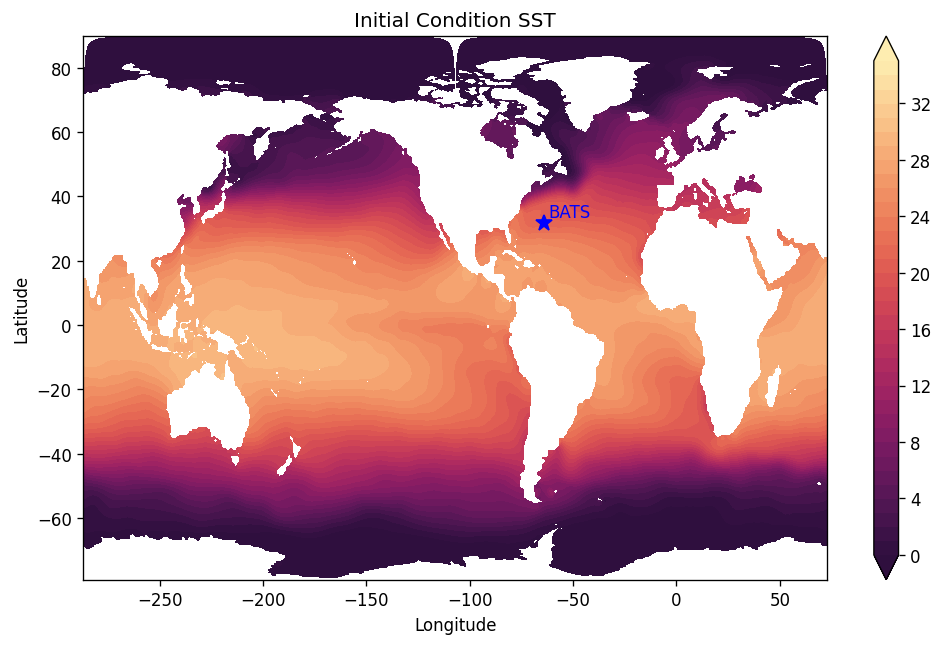

In [15]:
plt.figure(figsize=(10, 6),dpi=120)

plt.contourf(IC_FILE['LON'],IC_FILE['LAT'],IC_FILE['TEMP'][0,:],cmap=cmocean.cm.matter_r,vmin=0,vmax=35,levels=np.linspace(0,35,36),extend='both')
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Initial Condition SST')
plt.plot(lon_array[yloc,xloc],lat_array[yloc,xloc],'*b',markersize=10)

plt.text(lon_array[yloc,xloc]+2,lat_array[yloc,xloc]+2,'BATS',color='b')
plt.show()

In [16]:
#This takes 5 minutes to read in:
%cd /glade/scratch/mlevy/archive/g.e23b09.TL319_t061.G1850MOMMARBL_JRA.006/ocn/hist
OTHER_FLUX_FILE = xr.open_mfdataset('g.e23b09.TL319_t061.G1850MOMMARBL_JRA.006.mom6.h_bgc_monthly_00*',decode_times=False)
#print(OTHER_FLUX_FILE)


/glade/scratch/mlevy/archive/g.e23b09.TL319_t061.G1850MOMMARBL_JRA.006/ocn/hist


In [33]:
IC_FILE_COLUMN               = IC_FILE.isel(NLAT=[yloc-1,yloc], NLON=[xloc-1,xloc]).rename_dims({'NLON':'lon','NLAT':'lat'})#.expand_dims(dim={'LAT':1,'LON':1},axis=[1,2])
MARBL_FESEDFLUX_FILE_COLUMN  = MARBL_FESEDFLUX_FILE.isel(NLAT=[yloc-1,yloc], NLON=[xloc-1,xloc]).rename_dims({'NLON':'lon','NLAT':'lat'})#.expand_dims(dim={'LAT':1,'LON':1},axis=[1,2])
MARBL_FEVENTFLUX_FILE_COLUMN = MARBL_FEVENTFLUX_FILE.isel(NLAT=[yloc-1,yloc], NLON=[xloc-1,xloc]).rename_dims({'NLON':'lon','NLAT':'lat'})#.expand_dims(dim={'LAT':1,'LON':1},axis=[1,2])  #leaving braces around [xloc] and [yloc] preserves that dimension
OTHER_FLUX_FILE_COLUMN = OTHER_FLUX_FILE.isel(time=range(0,12),xh=[xloc-1,xloc],yh=[yloc-1,yloc]).rename_dims({'xh':'lon','yh':'lat'})


#print(IC_FILE_COLUMN)
# print( MARBL_FESEDFLUX_FILE_COLUMN)
# print(MARBL_FEVENTFLUX_FILE)
#print(OTHER_FLUX_FILE_COLUMN)


In [45]:
keys_flux = ['ATM_BLACK_CARBON_FLUX_CPL','SEAICE_BLACK_CARBON_FLUX_CPL','ATM_FINE_DUST_FLUX_CPL','ATM_COARSE_DUST_FLUX_CPL','SEAICE_DUST_FLUX_CPL']
FLUX_FILE_COLUMN = OTHER_FLUX_FILE_COLUMN[keys_flux]
#print(OTHER_FLUX_FILE_COLUMN)
print(FLUX_FILE_COLUMN)

<xarray.Dataset>
Dimensions:                       (lat: 2, lon: 2, time: 12)
Coordinates:
    xh                            (lon) float64 -64.67 -64.0
    yh                            (lat) float64 31.18 31.75
  * time                          (time) float64 15.5 45.0 74.5 ... 319.0 349.5
Dimensions without coordinates: lat, lon
Data variables:
    ATM_BLACK_CARBON_FLUX_CPL     (time, lat, lon) float64 dask.array<chunksize=(1, 2, 2), meta=np.ndarray>
    SEAICE_BLACK_CARBON_FLUX_CPL  (time, lat, lon) float64 dask.array<chunksize=(1, 2, 2), meta=np.ndarray>
    ATM_FINE_DUST_FLUX_CPL        (time, lat, lon) float64 dask.array<chunksize=(1, 2, 2), meta=np.ndarray>
    ATM_COARSE_DUST_FLUX_CPL      (time, lat, lon) float64 dask.array<chunksize=(1, 2, 2), meta=np.ndarray>
    SEAICE_DUST_FLUX_CPL          (time, lat, lon) float64 dask.array<chunksize=(1, 2, 2), meta=np.ndarray>
Attributes:
    filename:          g.e23b09.TL319_t061.G1850MOMMARBL_JRA.006.mom6.h_bgc_m...
    title:        

Text(0.5, 1.0, 'Fluxes contributing to iron flux, 1 years of monthly averages')

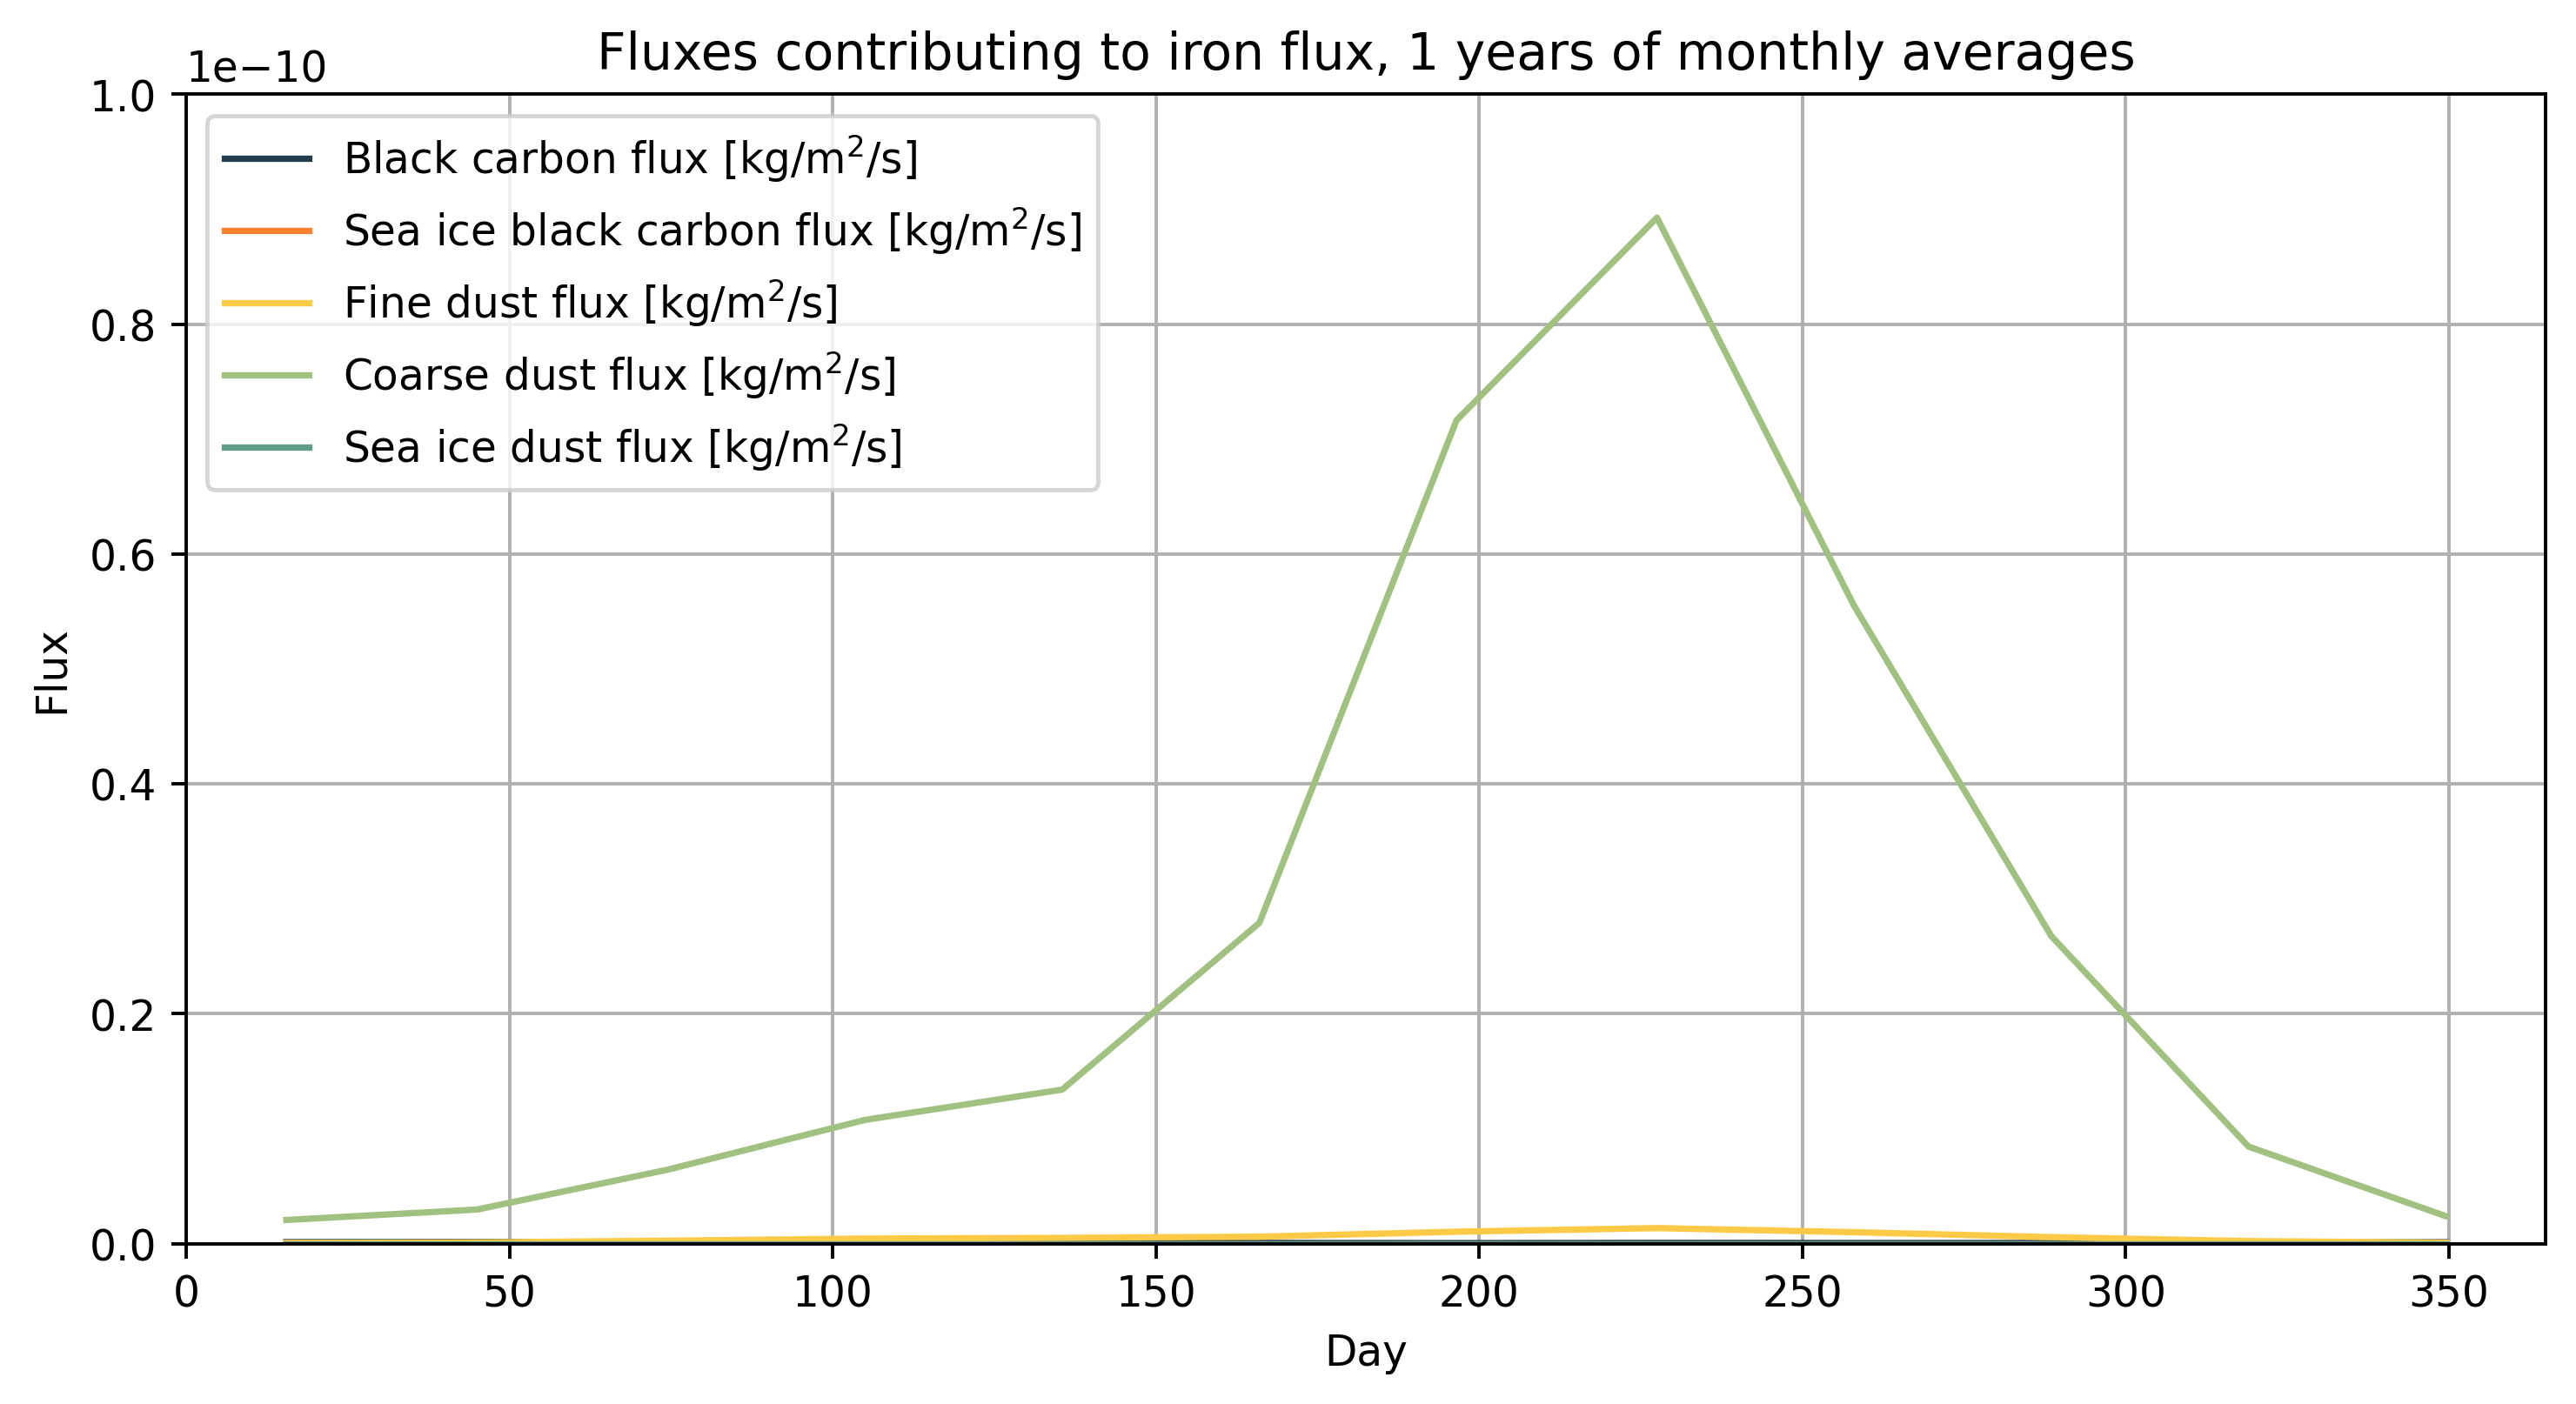

In [46]:
#FLUX_FILE_COLUMN
#IC_FILE_COLUMN

plt.figure(figsize=(10, 5),dpi=350)
plt.plot(FLUX_FILE_COLUMN.time,FLUX_FILE_COLUMN.ATM_BLACK_CARBON_FLUX_CPL[:,0,0],label='Black carbon flux [kg/m$^2$/s]',color='#233d4d')
plt.plot(FLUX_FILE_COLUMN.time,FLUX_FILE_COLUMN.SEAICE_BLACK_CARBON_FLUX_CPL[:,0,0],label='Sea ice black carbon flux [kg/m$^2$/s]',color='#fe7f2d')
plt.plot(FLUX_FILE_COLUMN.time,FLUX_FILE_COLUMN.ATM_FINE_DUST_FLUX_CPL[:,0,0],label='Fine dust flux [kg/m$^2$/s]',color='#fcca46')
plt.plot(FLUX_FILE_COLUMN.time,FLUX_FILE_COLUMN.ATM_COARSE_DUST_FLUX_CPL[:,0,0],label='Coarse dust flux [kg/m$^2$/s]',color='#a1c181')
plt.plot(FLUX_FILE_COLUMN.time,FLUX_FILE_COLUMN.SEAICE_DUST_FLUX_CPL[:,0,0],label='Sea ice dust flux [kg/m$^2$/s]',color='#619b8a')
plt.legend()
plt.ylabel('Flux')
plt.xlabel('Day')
plt.xlim([0,365]); plt.ylim([0,10e-11])
plt.grid()
plt.title('Fluxes contributing to iron flux, 1 years of monthly averages')

In [41]:
keys = list(IC_FILE_COLUMN.keys())
len(keys)

34

In [42]:
#keys

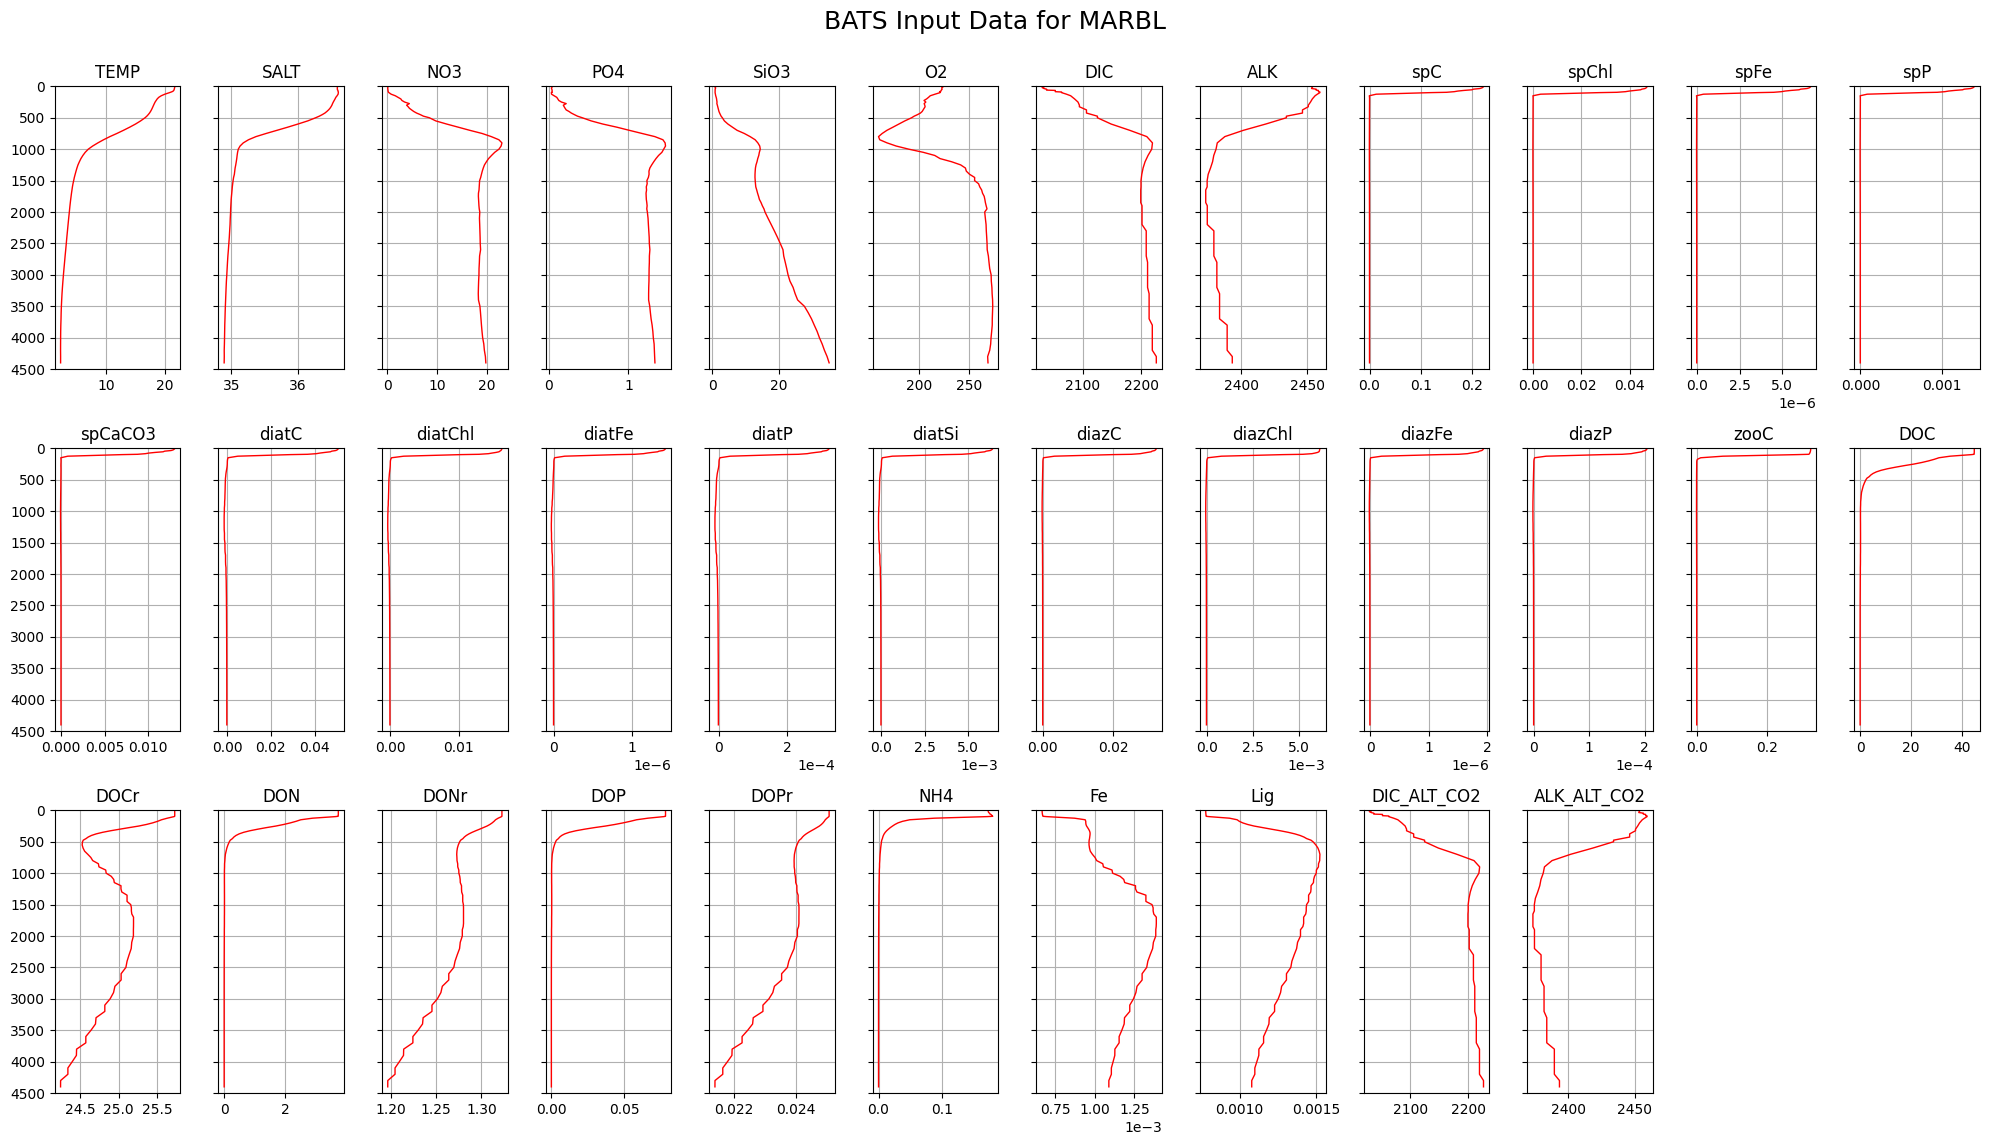

In [43]:
fig, axs = plt.subplots(nrows=3, ncols=12, figsize=(20, 12), sharey = True, dpi=100)
fig.suptitle("BATS Input Data for MARBL", fontsize=18, y=0.95)

for key, ax in zip(keys, axs.ravel()):
    ax.plot(IC_FILE_COLUMN[key][:,0,0],IC_FILE_COLUMN.DEPTH,'r',linewidth=1)

    ax.set_ylim([4500, 0])
    ax.set_title(key)
    ax.grid()
    #ax.set_xlabel(IC_FILE_COLUMN[key].units)
    ax.ticklabel_format(style='plain', axis='x')
    if key in ['spFe','diatFe','diatSi','diazChl','diatP','diazFe','diazP','Fe']:
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

fig.delaxes(axs[-1][-1])
fig.delaxes(axs[-1][-2])
fig.tight_layout(rect=[0, 0, 1, 0.95])


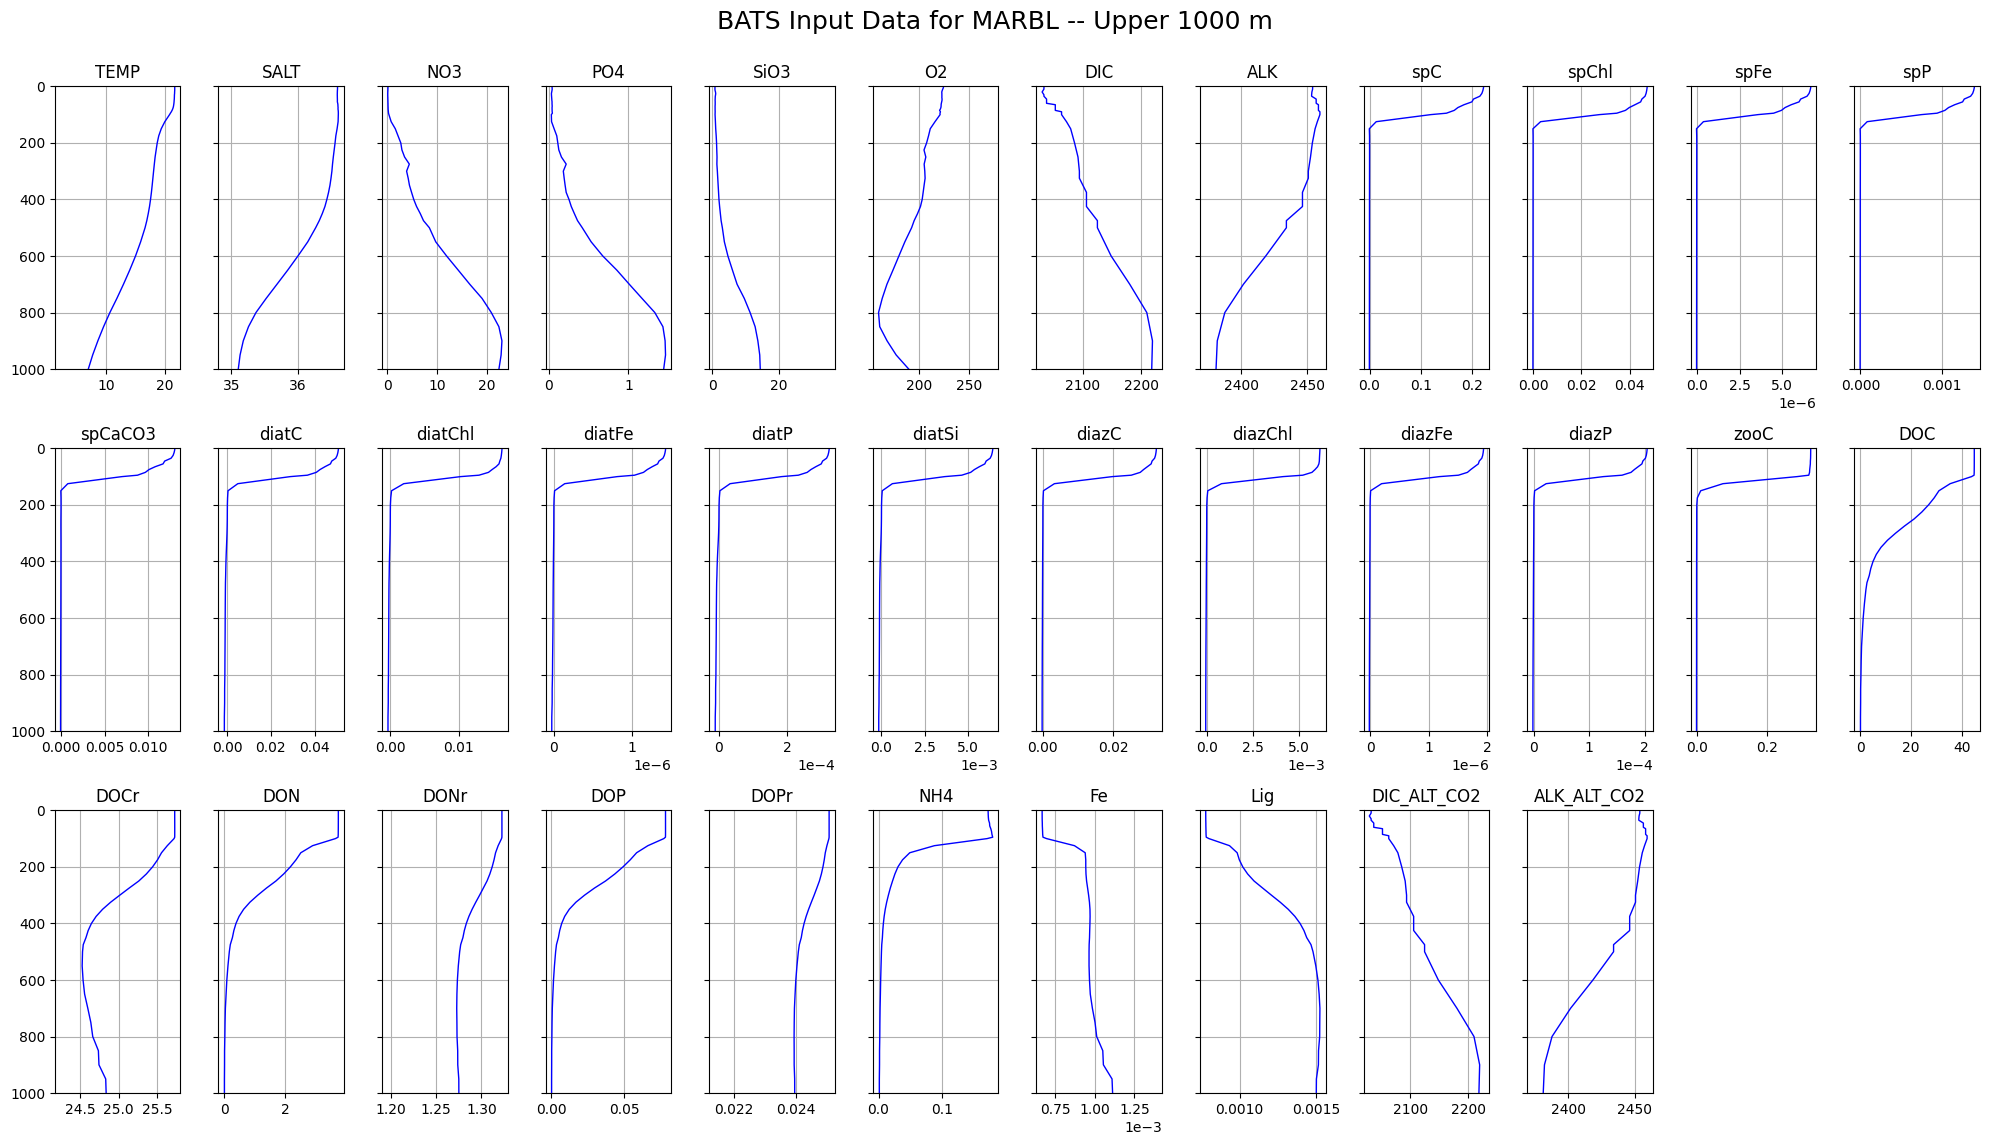

In [44]:
fig, axs = plt.subplots(nrows=3, ncols=12, figsize=(20, 12), sharey = True, dpi=100)
fig.suptitle("BATS Input Data for MARBL -- Upper 1000 m", fontsize=18, y=0.95)

for key, ax in zip(keys, axs.ravel()):
    ax.plot(IC_FILE_COLUMN[key][:,0,0],IC_FILE_COLUMN.DEPTH,'b',linewidth=1)

    ax.set_ylim([1000, 0])
    ax.set_title(key)
    ax.grid()
    #ax.set_xlabel(IC_FILE_COLUMN[key].units)
    ax.ticklabel_format(style='plain', axis='x')
    if key in ['spFe','diatFe','diatSi','diazChl','diatP','diazFe','diazP','Fe']:
        ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

fig.delaxes(axs[-1][-1])
fig.delaxes(axs[-1][-2])
fig.tight_layout(rect=[0, 0, 1, 0.95])

<xarray.Dataset>
Dimensions:                       (lat: 2, lon: 2, time: 12)
Coordinates:
    xh                            (lon) float64 -64.67 -64.0
    yh                            (lat) float64 31.18 31.75
  * time                          (time) float64 15.5 45.0 74.5 ... 319.0 349.5
Dimensions without coordinates: lat, lon
Data variables:
    ATM_BLACK_CARBON_FLUX_CPL     (time, lat, lon) float64 dask.array<chunksize=(1, 2, 2), meta=np.ndarray>
    SEAICE_BLACK_CARBON_FLUX_CPL  (time, lat, lon) float64 dask.array<chunksize=(1, 2, 2), meta=np.ndarray>
    ATM_FINE_DUST_FLUX_CPL        (time, lat, lon) float64 dask.array<chunksize=(1, 2, 2), meta=np.ndarray>
    ATM_COARSE_DUST_FLUX_CPL      (time, lat, lon) float64 dask.array<chunksize=(1, 2, 2), meta=np.ndarray>
    SEAICE_DUST_FLUX_CPL          (time, lat, lon) float64 dask.array<chunksize=(1, 2, 2), meta=np.ndarray>
Attributes:
    filename:          g.e23b09.TL319_t061.G1850MOMMARBL_JRA.006.mom6.h_bgc_m...
    title:        

## Finally save the MARBL column input files within the BATS input directory in my_single_column example directory

In [48]:

%cd /glade/u/home/eyankovsky/MOM6-examples/ocean_only/single_column/KPP_MARBL/INPUT/BATS/
%rm IC_FILE_COLUMN.nc MARBL_FESEDFLUX_FILE_COLUMN.nc MARBL_FEVENTFLUX_FILE_COLUMN.nc
IC_FILE_COLUMN.to_netcdf('IC_FILE_COLUMN.nc', 'w')
MARBL_FESEDFLUX_FILE_COLUMN.to_netcdf('MARBL_FESEDFLUX_FILE_COLUMN.nc','w')
MARBL_FEVENTFLUX_FILE_COLUMN.to_netcdf('MARBL_FEVENTFLUX_FILE_COLUMN.nc','w')
FLUX_FILE_COLUMN.to_netcdf('FLUX_FILE_COLUMN.nc','w')
%ls

testing_IC_FILE = xr.open_dataset('IC_FILE_COLUMN.nc')
testing_ICs = xr.open_dataset('ICs.nc')

/glade/u/home/eyankovsky/MOM6-examples/ocean_only/single_column/INPUT/BATS
FLUX_FILE_COLUMN.nc  ICs.nc                           MOM_override
forcing_monthly.nc   itides.nc                        WOA_column.nc
forcing.nc           MARBL_FESEDFLUX_FILE_COLUMN.nc
IC_FILE_COLUMN.nc    MARBL_FEVENTFLUX_FILE_COLUMN.nc


In [122]:
(1/1.5854895991882293e-08)/86400/365

2.0

## Restoring timescale

In [128]:
restoring = xr.open_dataset('/glade/p/cesmdata/cseg/inputdata/ocn/pop/gx1v6/forcing/ecosys_restore_inv_tau_POP_gx1v6_20170125.nc')

#print(restoring.RESTORE_INV_TAU )

print('max restoring inverse timescale in years is:',(1/(np.nanmax(restoring.RESTORE_INV_TAU)))/86400/365)

max restoring inverse timescale in years is: 2.0


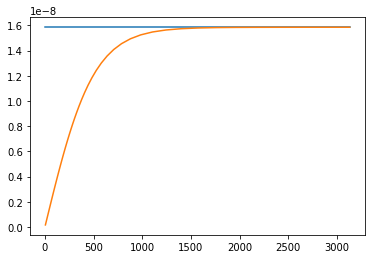

In [129]:
#plt.figure(figsize=(3, 2),dpi=150)

plt.plot(restoring.depth,restoring.RESTORE_INV_TAU[:,100,100])


plt.plot(restoring.depth,restoring.RESTORE_INV_TAU[:,100,100]*np.tanh(restoring.depth/500))


In [130]:
restoring['RESTORE_INV_TAU'] = restoring.RESTORE_INV_TAU*np.tanh(restoring.depth/500)
restoring['RESTORE_INV_TAU_MARGINAL_SEA_ONLY'] = restoring.RESTORE_INV_TAU_MARGINAL_SEA_ONLY*np.tanh(restoring.depth/500)


In [131]:
%cd /glade/u/home/eyankovsky/MOM6-examples/ocean_only/single_column/KPP_MARBL/INPUT/BATS/
%rm restoring_3D.nc

restoring.to_netcdf('restoring_3D.nc','w')
test = xr.open_dataset('restoring_3D.nc')
print(test)

/glade/u/home/eyankovsky/MOM6-examples/ocean_only/single_column/INPUT/BATS
<xarray.Dataset>
Dimensions:                            (depth: 60, nlat: 384, nlon: 320)
Coordinates:
  * depth                              (depth) float64 5.0 15.0 ... 5.375e+03
    TLONG                              (nlat, nlon) float64 ...
    TLAT                               (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT                                (nlat, nlon) int32 ...
    REGION_MASK                        (nlat, nlon) int32 ...
    RESTORE_INV_TAU                    (depth, nlat, nlon) float64 ...
    RESTORE_INV_TAU_MARGINAL_SEA_ONLY  (depth, nlat, nlon) float64 ...
Attributes:
    comment:  created by /glade/u/home/klindsay/ncl/gen_ecosys_restore_inv_ta...


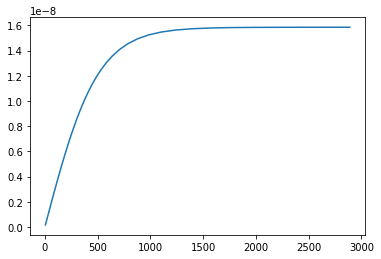

In [132]:
plt.plot(test.depth,test.RESTORE_INV_TAU[:,50,50])
